In [1]:
import tensorflow as tf
from keras import backend as K

# Clear the Keras session
K.clear_session()

# Optionally, force a garbage collection
import gc
gc.collect()


0

In [2]:
import os

# data
DATA = 'cropped_data' # original_data, cropped_data

# model
MODEL_NAME = 'TripletNet' # InceptionResNet, TripletNet
IMAGE_SIZE = 299

# hyperparameter
EPOCHS = 1000
LEARNING_RATE = 0.001
BATCH_SIZE = 128 # number of images in a single batch

# root path
ROOT_PATH = 'C:/Users/USER/Desktop/Git/capstone/Capstone'

# train/val data path
TRAIN_DATA_PATH = os.path.join(ROOT_PATH, DATA, 'train_data')
VAL_DATA_PATH = os.path.join(ROOT_PATH, DATA, 'val_data')

# result path
RESULT_PATH = os.path.join(ROOT_PATH, 'train_result')
EXPERIMENT_PATH = f"{MODEL_NAME}_{DATA}_{IMAGE_SIZE}_{EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}"
RESULT_FILE_PATH = os.path.join(RESULT_PATH, EXPERIMENT_PATH)

# tensorboard path
TSBOARD_PATH = os.path.join(RESULT_FILE_PATH, 'initial_tensorboard')
FINETUNE_TSBOARD_PATH = os.path.join(RESULT_FILE_PATH, 'finetune_tensorboard')

CHECKPOINT_PATH = os.path.join(RESULT_FILE_PATH, 'initial_checkpoint')
CHECKPOINT_FILE_PATH = os.path.join(CHECKPOINT_PATH, 'checkpoint-{epoch:03d}-{loss:03f}-{val_loss:03f}.weights.h5')

PRETRAINED_CHECKPOINT_PATH_1 = os.path.join(RESULT_PATH, f'InceptionResNet_{DATA}_{IMAGE_SIZE}_{EPOCHS}_{LEARNING_RATE}_{512}', 'finetune_checkpoint')
PRETRAINED_CHECKPOINT_PATH_2 = os.listdir(PRETRAINED_CHECKPOINT_PATH_1)[-1]
PRETRAINED_CHECKPOINT_PATH = os.path.join(PRETRAINED_CHECKPOINT_PATH_1, PRETRAINED_CHECKPOINT_PATH_2)

In [3]:
import tensorflow as tf
import os
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from pytz import timezone
from datetime import datetime
from train_config import *
from test_config import *
from utils import *
from import_data import Import_TripletNet_test_data
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from model.TripletNet import TripletNet_model
import numpy as np
import pickle
from tqdm import tqdm

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

train_data_path = TRAIN_DATA_PATH
test_data_path = TEST_DATA_PATH
image_size = IMAGE_SIZE
batch_size = BATCH_SIZE
epochs = EPOCHS
learning_rate = LEARNING_RATE
pretrained_checkpoint_path = PRETRAINED_CHECKPOINT_PATH

data_loader = Import_TripletNet_test_data(image_size, batch_size, train_data_path=train_data_path, test_data_path=test_data_path)
train_triplet_generator, test_triplet_generator = data_loader.build_generators()

model = TripletNet_model(image_size, pretrained_checkpoint_path).create_model()
model.summary()
model.compile()

checkpoint_path = os.path.join(CHECKPOINT_PATH, os.listdir(CHECKPOINT_PATH)[-1])
if checkpoint_path:
    print(f"Checkpoint found: {checkpoint_path}")
    model.load_weights(checkpoint_path, by_name=True)
else:
    print("No checkpoint found")

Found 65098 images belonging to 7 classes.
Found 13952 images belonging to 7 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization_203 (Ba  (None, 128)              512       
 tchNormalization)                       

In [4]:
from collections import defaultdict

embedding_sum = defaultdict(lambda: np.zeros(128))
embedding_count = defaultdict(int)
total_batches = len(train_triplet_generator)
batch_count = 0

print("Starting to process batches...")
for batch, labels in train_triplet_generator:
	if batch_count >= total_batches:
		break 
	batch_count += 1 
	print(f"Processing batch {batch_count}/{total_batches}") 
	embeddings = model.predict(batch, verbose=0) # (batch, 128)
	labels = labels.astype(int) # (batch, )
	for emb, label in zip(embeddings, labels):
		embedding_sum[label] += emb
		embedding_count[label] += 1

Starting to process batches...
Processing batch 1/509
Processing batch 2/509
Processing batch 3/509
Processing batch 4/509
Processing batch 5/509
Processing batch 6/509
Processing batch 7/509
Processing batch 8/509
Processing batch 9/509
Processing batch 10/509
Processing batch 11/509
Processing batch 12/509
Processing batch 13/509
Processing batch 14/509
Processing batch 15/509
Processing batch 16/509
Processing batch 17/509
Processing batch 18/509
Processing batch 19/509
Processing batch 20/509
Processing batch 21/509
Processing batch 22/509
Processing batch 23/509
Processing batch 24/509
Processing batch 25/509
Processing batch 26/509
Processing batch 27/509
Processing batch 28/509
Processing batch 29/509
Processing batch 30/509
Processing batch 31/509
Processing batch 32/509
Processing batch 33/509
Processing batch 34/509
Processing batch 35/509
Processing batch 36/509
Processing batch 37/509
Processing batch 38/509
Processing batch 39/509
Processing batch 40/509
Processing batch 4

In [5]:
print("Starting to compute mean embeddings...")
database = {label: embedding_sum[label] / embedding_count[label] for label in embedding_sum}

Starting to compute mean embeddings...


In [6]:
print("Saving database...")
with open(f"{TEST_RESULT_FILE_PATH}/database.pkl", 'wb') as f:
    pickle.dump(database, f)

Saving database...


In [7]:
def predict_closest_embedding(embedding, database):
    min_dist = float('inf')
    identity = None

    for label, db_emb in database.items():
        dist = np.linalg.norm(embedding - db_emb)
        if dist < min_dist:
            min_dist = dist
            identity = label
    
    return identity, min_dist

y_true = []
y_pred = []
total_batches = len(test_triplet_generator)
batch_count = 0

print("Starting to evaluate batches...")
for batch, labels in test_triplet_generator:
	if batch_count >= total_batches:
		break 
	batch_count += 1 
	print(f"Processing batch {batch_count}/{total_batches}") 
	embeddings = model.predict(batch, verbose=0) # (batch, 128)
	labels = labels.astype(int) # (batch, )
	for emb, true_label in zip(embeddings, labels):
		pred_label, _ = predict_closest_embedding(emb, database)
		y_true.append(true_label)
		y_pred.append(pred_label)

Starting to evaluate batches...
Processing batch 1/109
Processing batch 2/109
Processing batch 3/109
Processing batch 4/109
Processing batch 5/109
Processing batch 6/109
Processing batch 7/109
Processing batch 8/109
Processing batch 9/109
Processing batch 10/109
Processing batch 11/109
Processing batch 12/109
Processing batch 13/109
Processing batch 14/109
Processing batch 15/109
Processing batch 16/109
Processing batch 17/109
Processing batch 18/109
Processing batch 19/109
Processing batch 20/109
Processing batch 21/109
Processing batch 22/109
Processing batch 23/109
Processing batch 24/109
Processing batch 25/109
Processing batch 26/109
Processing batch 27/109
Processing batch 28/109
Processing batch 29/109
Processing batch 30/109
Processing batch 31/109
Processing batch 32/109
Processing batch 33/109
Processing batch 34/109
Processing batch 35/109
Processing batch 36/109
Processing batch 37/109
Processing batch 38/109
Processing batch 39/109
Processing batch 40/109
Processing batch 

Saving results...
test_accuracy: 0.24025229357798164, test_precision: 0.22713361619039477, test_recall: 0.24688323065668985
              precision    recall  f1-score   support

           0    0.28661   0.06089   0.10044      2250
           1    0.25749   0.18711   0.21673      2250
           2    0.24894   0.28667   0.26647      2250
           3    0.11702   0.01833   0.03170      1800
           4    0.20651   0.50389   0.29296      1800
           5    0.20391   0.04053   0.06762      1801
           6    0.26945   0.63076   0.37760      1801

    accuracy                        0.24025     13952
   macro avg    0.22713   0.24688   0.19336     13952
weighted avg    0.23074   0.24025   0.19348     13952



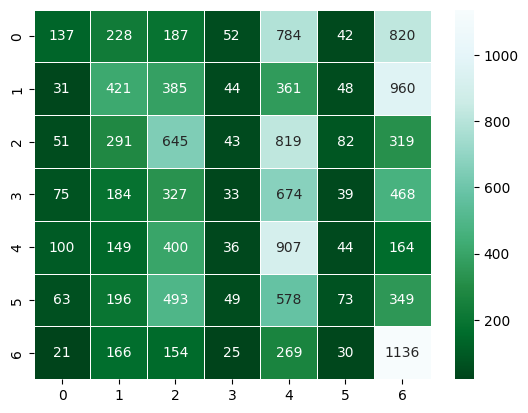

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score

print("Saving results...")
y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

conf_mat = confusion_matrix(y_true, y_pred)
df_conf_mat = pd.DataFrame(conf_mat, columns=[str(i) for i in range(conf_mat.shape[0])],
                           index=[str(i) for i in range(conf_mat.shape[1])])
sns_heatmap = sns.heatmap(data=df_conf_mat, annot=True, fmt='d', linewidths=.5, cmap='BuGn_r')
sns_heatmap.get_figure().savefig(f"{TEST_RESULT_FILE_PATH}/confusion_matrix.png")

target_names = [str(i) for i in range(conf_mat.shape[0])]
report = classification_report(y_true, y_pred, digits=5, target_names=target_names)

with open(f"{TEST_RESULT_FILE_PATH}/result.txt", "w") as file:
    file.write(f"test_accuracy: {accuracy}, test_precision: {precision}, test_recall: {recall}\n")
    file.write(report)

print(f"test_accuracy: {accuracy}, test_precision: {precision}, test_recall: {recall}")
print(report)